In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import matplotlib.pylab as plt
import matplotlib.cm as cmap
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.io
import theano.tensor as tt

Using cuDNN version 7003 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


### Covariance Kernel

In [2]:
def exponential_cov(x, y, gamma):
    return np.exp(-(gamma/(2))*np.subtract.outer(x, y)**2)

In [3]:
def covariance(kernel, X1, X2, params): 
    return kernel(X1, X2, params) 

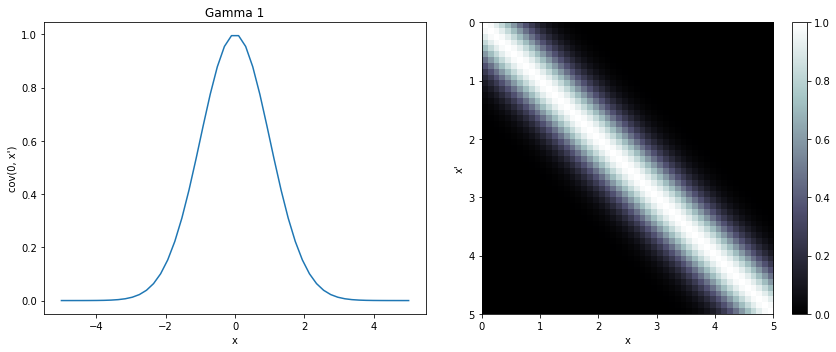

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
xrange = np.linspace(-5, 5)
ax1.plot(xrange, covariance(exponential_cov, 0, xrange, 1))
ax1.set_xlabel('x')
ax1.set_ylabel("cov(0, x')")
ax1.set_title("Gamma 1")

z = np.array([covariance(exponential_cov, xrange, xprime, 1) for xprime in xrange])
ims = ax2.imshow(z, cmap=cmap.bone, 
       interpolation='none', 
       extent=(0, 5, 5, 0))
ax2.set_xlabel('x')
ax2.set_ylabel("x'")
plt.colorbar(ims, ax=ax2)

plt.tight_layout();

In [5]:
n = 50
j = 20
Xtest = np.linspace(-5, 5, n).reshape(-1,1)
K_ = covariance(exponential_cov, Xtest, Xtest, 1)
K_= K_.squeeze()

In [6]:
K_ = covariance(exponential_cov, Xtest, Xtest, 1)
K_= K_.squeeze()

In [7]:
L = np.linalg.cholesky(K_ + 1e-5*np.eye(n))
f_prior = np.dot(L, np.random.normal(0, 1, size=(n,j)))

Text(0,0.5,'f(x)')

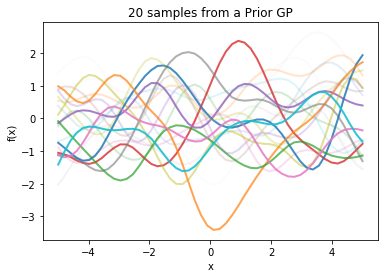

In [8]:
for i in range(j):
    y = f_prior[:,i]
    plt.plot(Xtest, y,alpha=np.random.rand(), lw=2)
plt.title("20 samples from a Prior GP")
plt.xlabel('x'); plt.ylabel('f(x)')

## Noiseless Regression
In the last excercise, we simply sampled from an infinitely flexible prior GP. Now we shall try to sample from the posterior which is the process of reigning a GP to observed points. We will be using the conditional property of Gaussians to condition the posterior GP on observed data. We also assume that there's no noise, thus, we do not model the error.

In [9]:
x=np.arange(0,10,0.5)
xtrain, xtest = train_test_split(x)
xtrain = np.sort(xtrain)
xtest = np.sort(xtest)

### Conditional equation
$$p(x_1 \mid x_2) = \mathcal{N}(\mu_1 + \Sigma_{12}\Sigma_2^{-1}(x_2-\mu_2), 
\Sigma_1-\Sigma_{12}\Sigma_2^{-1}\Sigma_{12}^T)$$

In [10]:
def conditional(x_new, x, kernel, gamma):
    sigma12 = covariance(kernel, x_new, x, gamma)
    sigma2inv = np.linalg.inv(covariance(kernel, x, x, gamma))
    sigma1 = covariance(kernel, x_new, x_new, gamma)
    
    mu = np.dot(np.dot(sigma12, sigma2inv), function(x))
    sigma = sigma1 - np.dot(np.dot(sigma12, sigma2inv), sigma12.T)
    return mu, sigma

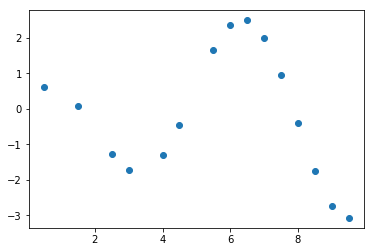

In [11]:
def function(x):
    return x**.5*np.cos(x)
plt.plot(xtrain, function(xtrain), 'o');

In [12]:
x_pred = np.linspace(0, 10, 1000)

In [13]:
gamma = 3
mu_new, s_new = conditional(x_pred, xtrain, exponential_cov, gamma)
#Standard deviation is the error
std = np.sqrt(np.diagonal(s_new))

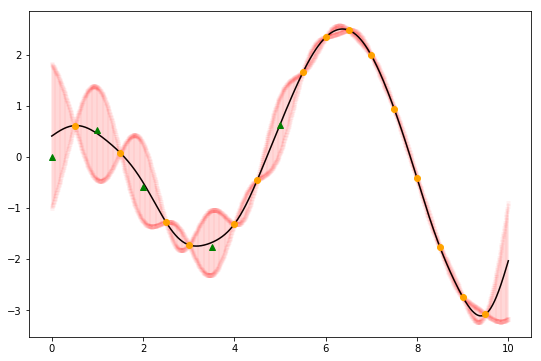

In [14]:
plt.figure(figsize=(9,6))
ax = plt.gca()
plt.errorbar(x_pred, mu_new, yerr=1.96*std, capsize=2, capthick=5, alpha=0.05, color='red');
plt.plot(x_pred, mu_new, c='black');
plt.plot(xtrain, function(xtrain), 'o',c='orange');
plt.plot(xtest, function(xtest), '^', c='green');


Text(0,0.5,'f(x)')

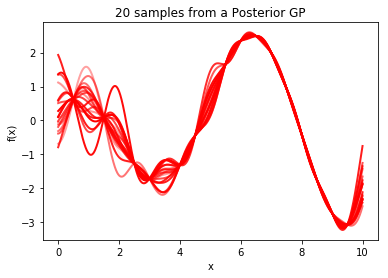

In [15]:
for i in range(20):
    y = np.random.multivariate_normal(mu_new, s_new)
    plt.plot(x_pred, y,alpha=np.random.rand(), lw=2, c='red')
plt.title("20 samples from a Posterior GP")
plt.xlabel('x'); plt.ylabel('f(x)')

What happens when we have noise, like almost always? That is, when we have a function

$$y = f(x) + N(0,\sigma^2)$$

Notice that both terms are Gaussians and noiseless regression is trivially done by adding the $\sigma$ to the function. The new plot should capture uncertainty along all the points. I skip this excercise and jump straight into inference.

## Learning
In most learning problems, values for the hyper-parameters such as the gamma value of the SE kernel would be unkown. 2 key methods to estimate these include 
- Empirical Bayes or MLE(with cross validation)
- Full Bayesian Estimation

The more Bayesian latter approach is used below with PyMC3 library.

In [16]:
mat = scipy.io.loadmat('data/olympics.mat')
olympics = mat['male100'][:, :2]

In [17]:
datx = olympics[:,0]
daty = olympics[:,1]

In [18]:
X_train, X_test, y, y_test = train_test_split(
            datx, daty, test_size=0.33)

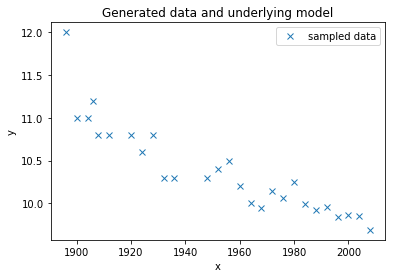

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(datx, daty, 'x', label='sampled data')
plt.legend(loc=0);

In [35]:
with pm.Model() as model:
# priors on the covariance function hyperparameters
    length_scale = pm.HalfCauchy('ls', 1)
    scale = pm.HalfCauchy('s', 1)
    
    K = (scale**2) * pm.gp.cov.ExpQuad(1, length_scale) 
    noise = pm.HalfCauchy('σ', 1)

    gp = pm.gp.Marginal(cov_func=K)
    gp.marginal_likelihood('estimate', X=X_train.reshape(-1,1), 
                           y=y, noise=noise)

In [37]:
with model:
    trace = pm.sample(1000, start=start, chains=2, njobs=1)

logp = -73.757, ||grad|| = 0.11078: 100%|██████████| 66/66 [00:00<00:00, 388.90it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [σ_log__, s_log__, ls_log__]
100%|██████████| 1500/1500 [00:16<00:00, 88.94it/s]


In [110]:
pm.summary(trace)
pm.traceplot(trace, varnames=['ls', 's', 'σ']);

TypeError: Ambiguous name: y_preds - please check the names of the inputs of your function for duplicates.

In [40]:
X_pred = np.linspace(1800, 2100, 100).reshape(-1, 1)

In [41]:
with model:
    pred = gp.conditional("preds", X_pred, tr)
    samples = pm.sample_ppc(trace, vars=[pred], samples=200)

100%|██████████| 200/200 [00:01<00:00, 174.19it/s]


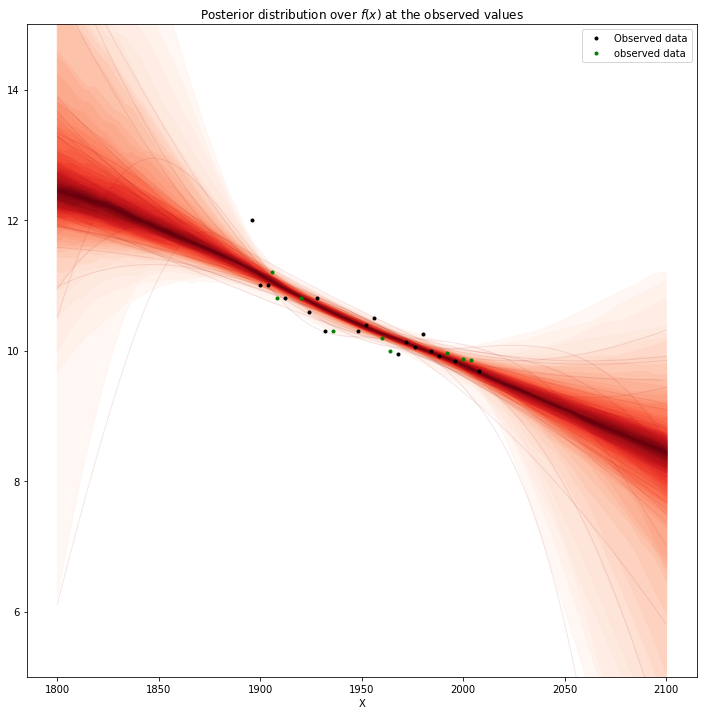

In [42]:
# plot the results
fig = plt.figure(figsize=(12,12)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, samples["preds"], X_pred);

# plot the data and the true latent function
plt.plot(X_train, y, 'ok', ms=3, alpha=1, label="Observed data", c='black');
plt.plot(X_test, y_test, 'ok', c='green', ms=3, alpha=1.0, label="observed data");

# axis labels and title
plt.xlabel("X"); 
plt.ylim([5,15]);

plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

In [43]:
with model:
    y_pred = gp.conditional("y_preds", X_pred, pred_noise=True)
    y_samples = pm.sample_ppc([start], vars=[y_pred], samples=2000)

100%|██████████| 2000/2000 [00:05<00:00, 372.66it/s]


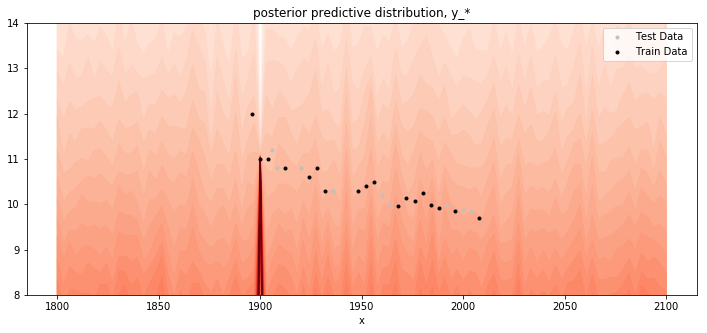

In [44]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_preds"], X_pred, plot_samples=False);

# overlay a scatter of one draw of random points from the
#   posterior predictive distribution
plt.plot(X_test, y_test, 'ok', c='silver', ms=3, alpha=1.0, label="Test Data");

# plot original data and true function
plt.plot(X_train, y, 'ok', ms=3, alpha=1.0, label="Train Data");

plt.xlabel("x"); plt.ylim([8,14]);
plt.title("posterior predictive distribution, y_*"); plt.legend();


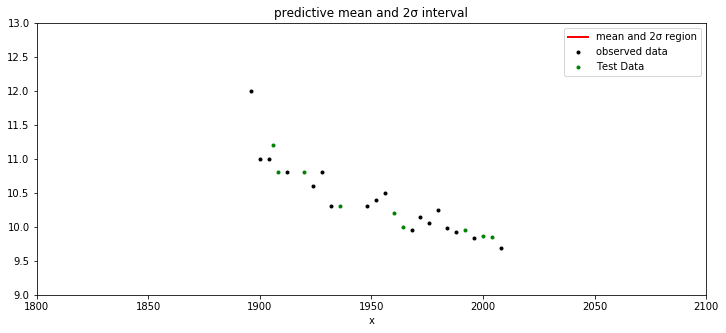

In [30]:
# predict
mu, var = gp.predict(X_pred, point=map_marginal, diag=True, pred_noise=False)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_pred, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_pred, mu + 1.96*sd, 'r', lw=1); plt.plot(X_pred, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_pred.flatten(), mu - 1.96*sd, mu + 1.96*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X_train, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X_test, y_test, 'ok',  c='green', ms=3, alpha=1.0, label="Test Data");

plt.xlabel("x"); plt.ylim([9,13]); plt.xlim([1800,2100]);
plt.title("predictive mean and 2σ interval"); plt.legend();

In [101]:
trace.get_values('ls_log__')

array([ 6.32742947,  6.49179308,  5.4174805 , ...,  4.94936186,
        5.36761795,  6.07536013])

In [102]:
ndict = {}
for x in trace.varnames:
    val = np.mean(trace.get_values(x))
    ndict[x]=val

In [103]:
ndict

{'ls': 484.24274803577953,
 'ls_log__': 5.8021473075842147,
 's': 11.525760015098497,
 's_log__': 2.2877292026343476,
 'σ': 0.27006651173742874,
 'σ_log__': -1.329440934815203}

In [109]:
mu, var = gp.predict(X_test.reshape(-1,1), point=ndict, diag=True)

print (np.sum((y_test-mu)**2))

0.255497592669


## Sparse GP

In [68]:
with model:
    y_pred = gp.conditional("y_test", X_test.reshape(-1,1), pred_noise=True)
    y_samples = pm.sample_ppc(trace, vars=[y_pred], samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 348.90it/s]


In [69]:
ypred = np.mean(y_samples['y_test'], 0)

In [108]:
print (np.sum((y_test-ypred)**2))

0.225758447482
